In [102]:
import os
import torch

import torchvision.datasets as datasets

In [103]:
path_resolution_56 = "/private/home/francoisporcher/imagenet_embeddings/resolution_56"
batch_name = "batch_00000_rank_0.pt"
batch_path = os.path.join(path_resolution_56, batch_name)
batch = torch.load(batch_path)
embeddings, labels = batch['embeddings'], batch['labels']


In [104]:
from torchvision.transforms.v2 import Compose, RandomHorizontalFlip, ToDtype, Lambda, Resize
from torchvision.transforms.v2.functional import pil_to_tensor

resolution = 252

def get_train_transform(resolution = resolution):
    return Compose(
        [
            pil_to_tensor,  # PIL → uint8 Tensor in [0..255]
            Resize((resolution, resolution)),
            RandomHorizontalFlip(p=0.5),  # 50% chance horizontal flip
            ToDtype(torch.float32),  # uint8 → float32, still [0..255]
            Lambda(lambda t: t / 255.0),  # now [0..1]
        ]
    )
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [105]:
model = torch.hub.load("facebookresearch/dinov2", "dinov2_vitb14")
model.eval()
model.to(device)

imagenet_dir = "/datasets01/imagenet_full_size/061417"
transform_train = get_train_transform()
dataset_train = datasets.ImageFolder(imagenet_dir, transform=transform_train)

Using cache found in /private/home/francoisporcher/.cache/torch/hub/facebookresearch_dinov2_main


/private/home/francoisporcher/.conda/envs/dinov2/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


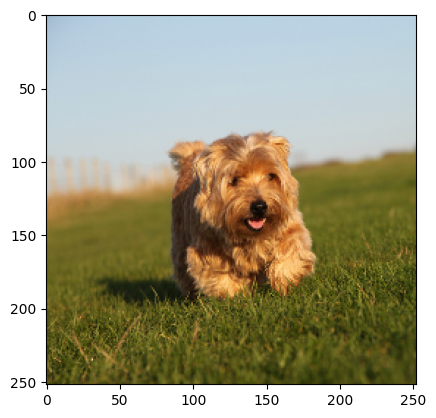

In [106]:
idx =3
sample = dataset_train[idx]

image, label = sample[0], sample[1]
import matplotlib.pyplot as plt
from einops import rearrange

image_rgb = rearrange(image, "b h w -> h w b")

plt.imshow(image_rgb)
image = image.unsqueeze(0)

assert image.ndim == 4 and image.shape[0] == 1, f"Expected shape (1, C, H, W), got {image.shape}"

In [107]:
image = image.to(device)

In [108]:
image.device

device(type='cuda', index=0)

In [109]:
outputs = model.forward_features(image)
x_norm_patchtokens = outputs["x_norm_patchtokens"].cpu()
x_norm_patchtokens = x_norm_patchtokens.squeeze(0).detach().numpy()

In [110]:
patch_size = 14
num_tokens, d = x_norm_patchtokens.shape
H = resolution // patch_size
W = resolution // patch_size
print(num_tokens, d, H, W)

324 768 18 18


In [134]:
from sklearn.decomposition import PCA



n_components_background = 1
pca_background = PCA(n_components=n_components_background)

data_transformed = pca_background.fit_transform(x_norm_patchtokens)

data_rearranged=rearrange(data_transformed, "(H W) d -> H W d", H=H, W=W)

In [135]:
data_renorm = (data_rearranged - data_rearranged.min()) / (data_rearranged.max() - data_rearranged.min())
print(data_renorm.shape, data_renorm.min(), data_renorm.max())


(18, 18, 1) 0.0 1.0


In [136]:
import lovely_tensors as lt
lt.monkey_patch()

# set threshold

mask = data_renorm < 0.55



In [137]:
data_renorm[mask] = 0.0

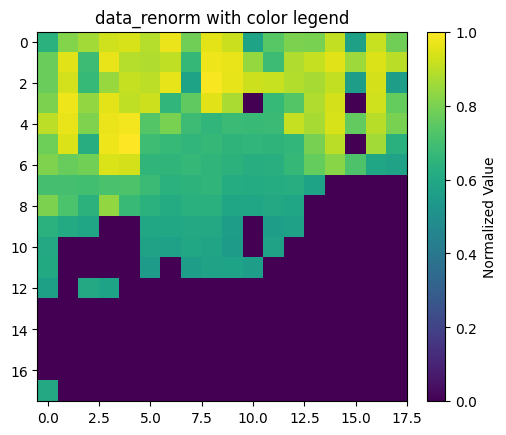

In [140]:
import matplotlib.pyplot as plt

im = plt.imshow(data_renorm, vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Normalized Value')
plt.title("data_renorm with color legend")
plt.show()

In [148]:
pca_rgb = PCA(n_components = 3)

data_rgb = pca_rgb.fit_transform(x_norm_patchtokens)

data_rearranged_rgb=rearrange(data_rgb, "(H W) d -> H W d", H=H, W=W)

In [149]:
data_rearranged_rgb.shape

(18, 18, 3)

In [159]:
import numpy as np
mask_repeated = np.repeat(mask, 3, axis=-1)

In [160]:
data_renorm_rgb = (data_rearranged_rgb - data_rearranged_rgb.min()) / (data_rearranged_rgb.max() - data_rearranged_rgb.min())
print(data_renorm_rgb.shape, data_renorm_rgb.min(), data_renorm_rgb.max())


data_renorm_rgb[mask_repeated] = 0.0

(18, 18, 3) 0.0 1.0


In [161]:
data_renorm_rgb.shape

(18, 18, 3)

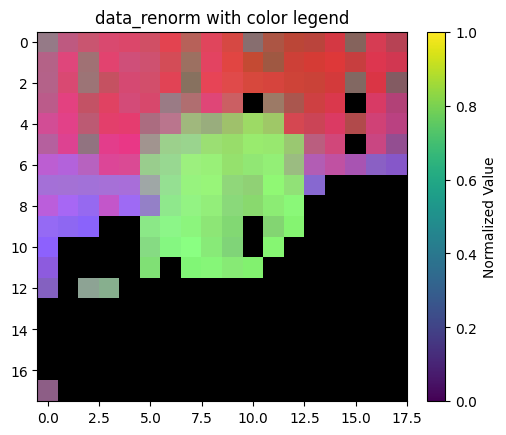

In [162]:
import matplotlib.pyplot as plt

im = plt.imshow(data_renorm_rgb, vmin=0, vmax=1)
plt.colorbar(im, fraction=0.046, pad=0.04, label='Normalized Value')
plt.title("data_renorm with color legend")
plt.show()